В этом notebook мы будем работать над улучшением метрик бейслайн моделей, путем дополнительных преобразований с данными. Существует 2 подхода:

1. Тестировать каждое преобразование отдельно и сравнивать с бейслайном, затем выбрать только лучшие и скомбинировать их
2. Поочередно применять удачные преобразования, сравнивая результат каждого нового преобразования с результатом предыдущего (итеративный подход)

Здесь мы будем использовать первый подход

## 1. Предобработка
Выполняем все те же операции, что и в бейслайне

In [1]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, TargetEncoder
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import helper as h
import random

In [3]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [4]:
df = pd.read_csv("data.csv")

In [5]:
# Общие преобразования
df_preprocessed = df.copy()
df_preprocessed = df_preprocessed.drop(columns=['Loan_ID'])
df_preprocessed['Credit_History'] = df_preprocessed['Credit_History'].fillna(2)
df_preprocessed['Dependents'] = np.where(df_preprocessed['Dependents'] == '3+', 3, df_preprocessed['Dependents'])
df_preprocessed['Dependents'] = pd.to_numeric(df_preprocessed['Dependents'])
df_preprocessed['Loan_Status'] = np.where(df_preprocessed['Loan_Status'] == 'Y', 1, 0)
df_preprocessed['Loan_Amount_Term'] = pd.to_numeric(df_preprocessed['Loan_Amount_Term'])

In [6]:
X, y = h.divide_data(df_preprocessed, 'Loan_Status')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [7]:
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
numeric_cols = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
most_frequent_numeric_cols = ['Dependents', 'Loan_Amount_Term']
most_frequent_cat_cols = ['Gender', 'Married', 'Self_Employed']
mean_imputer_cols = ['LoanAmount']
category_orders = [
    ['Male', 'Female'], # gender
    ['No', 'Yes'], # married                         
    ['Not Graduate', 'Graduate'], # education    
    ['No', 'Yes'], # self employed
    ['Rural', 'Semiurban', 'Urban'] # property area        
]

# уже знакомый нам пайплайн
preprocessor = Pipeline([
    ('most_frequent_impute', ColumnTransformer(
        [
            ('most_frequent_numeric', SimpleImputer(strategy='most_frequent'), most_frequent_numeric_cols),
            ('most_frequent_cat', SimpleImputer(strategy='most_frequent'), most_frequent_cat_cols)
        ],
        remainder='passthrough', 
        verbose_feature_names_out=False
    )),

    ('mean_impute', ColumnTransformer(
        [('mean', SimpleImputer(strategy='mean'), mean_imputer_cols)],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    
    ('encode', ColumnTransformer(
        [('encoder', OrdinalEncoder(categories=category_orders), categorical_cols)],
        remainder='passthrough',
        verbose_feature_names_out=False
    ))
])
preprocessor.set_output(transform="pandas")

Pipeline(steps=[('most_frequent_impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('most_frequent_numeric',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Dependents',
                                                   'Loan_Amount_Term']),
                                                 ('most_frequent_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Gender', 'Married',
                                                   'Self_Employed'])],
                                   verbose_feature_names_out=False)),
                ('mean_impute',
                 Colum...
                                                  ['LoanAmount'])],
                                   verbose_feature_names_out=False)),
                ('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(categories=[['Male',
                                                                              'Female'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Not '
                                                                              'Graduate',
                                                                              'Graduate'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Rural',
                                                                              'Semiurban',
                                                                              'Urban']]),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])],
                                   verbose_feature_names_out=False))])

In [8]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [9]:
# сохраним все бейслайн модели в виде списка для удобства
models = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED))
]

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

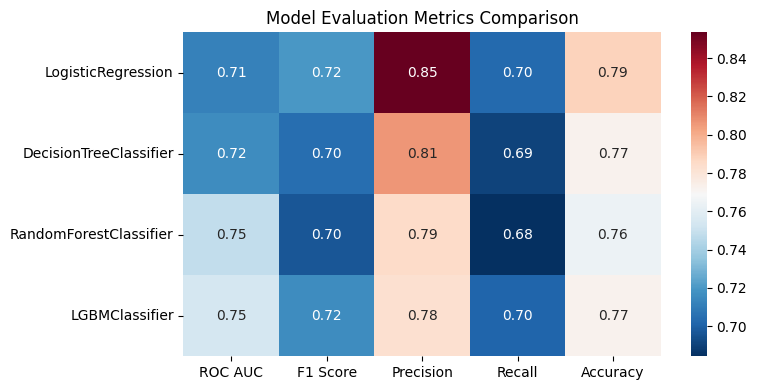

In [10]:
initial_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_preprocessed,
    y_train=y_train,
    X_test=X_test_preprocessed,
    y_test=y_test
)

## 2. Преобразования данных и feature engineering

### 2.1 Логарифмическое преобразование
В нашем датасете имеются "денежные" признаки ApplicantIncome, CoapplicantIncome, LoanAmount, которые имеют асимметричное распределение. Логарифмирование позволит сделать их более нормальными

#### 2.1.1 Без удаления столбцов

In [11]:
X_train_log = X_train_preprocessed.copy()
X_test_log = X_test_preprocessed.copy()

In [12]:
X_train_log['ApplicantIncomeLog'] = np.log1p(X_train_log['ApplicantIncome'])
X_train_log['CoapplicantIncomeLog'] = np.log1p(X_train_log['CoapplicantIncome'])
X_train_log['LoanAmountLog'] = np.log1p(X_train_log['LoanAmount'])

X_test_log['ApplicantIncomeLog'] = np.log1p(X_test_log['ApplicantIncome'])
X_test_log['CoapplicantIncomeLog'] = np.log1p(X_test_log['CoapplicantIncome'])
X_test_log['LoanAmountLog'] = np.log1p(X_test_log['LoanAmount'])

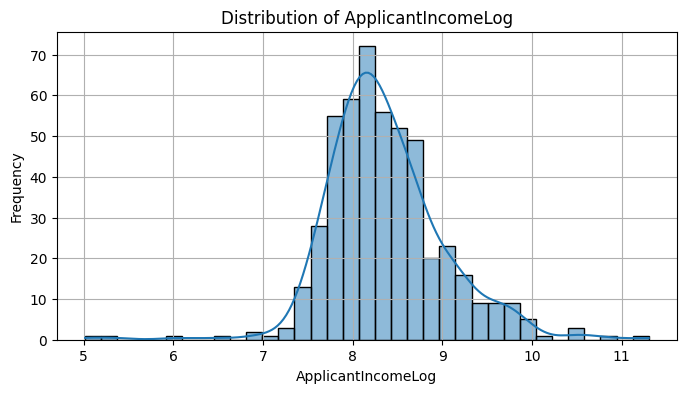

In [13]:
h.plot_hist_numeric(X_train_log, 'ApplicantIncomeLog')

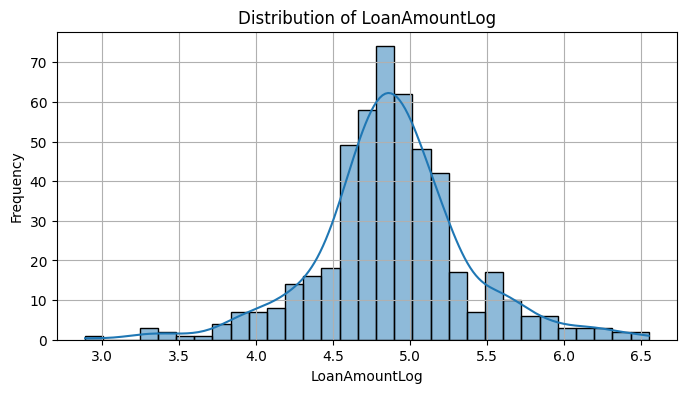

In [14]:
h.plot_hist_numeric(X_train_log, 'LoanAmountLog')

В результате логарифмирования наши распределения стали ближе к нормальным

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

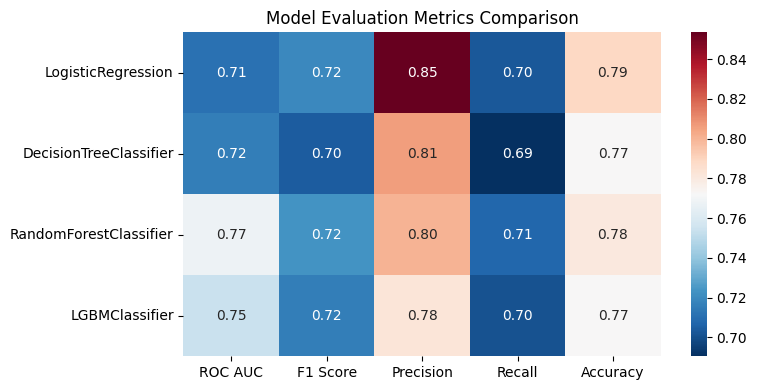

In [15]:
log_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_log,
    y_train=y_train,
    X_test=X_test_log,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.000291  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier  0.020349  0.026276   0.015177  0.023256   0.01626
 LGBMClassifier          0.000000  0.000000   0.000000  0.000000   0.00000)

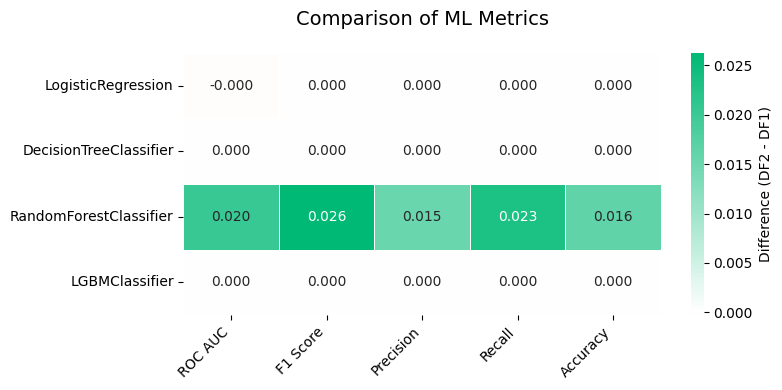

In [16]:
# сравним изначальные метрики с метриками после логарифмирования и выведем график
h.compare_metrics_heatmap(initial_metrics, log_metrics)

Преобразование повлияло только на случайный лес и улучшило его показатели в среднем на 2%

#### 2.1.2 С удалением исходных столбцов

In [17]:
X_train_log_delete = X_train_preprocessed.copy()
X_test_log_delete = X_test_preprocessed.copy()

In [18]:
X_train_log_delete['ApplicantIncome'] = np.log1p(X_train_log_delete['ApplicantIncome'])
X_train_log_delete['CoapplicantIncome'] = np.log1p(X_train_log_delete['CoapplicantIncome'])
X_train_log_delete['LoanAmount'] = np.log1p(X_train_log_delete['LoanAmount'])

X_test_log_delete['ApplicantIncome'] = np.log1p(X_test_log_delete['ApplicantIncome'])
X_test_log_delete['CoapplicantIncome'] = np.log1p(X_test_log_delete['CoapplicantIncome'])
X_test_log_delete['LoanAmount'] = np.log1p(X_test_log_delete['LoanAmount'])

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

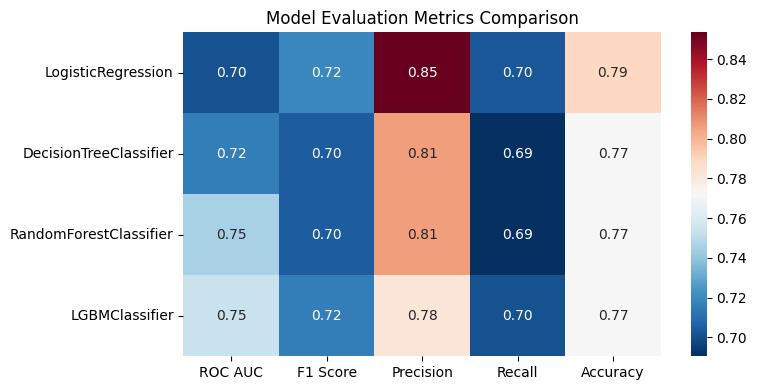

In [19]:
log_delete_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_log_delete,
    y_train=y_train,
    X_test=X_test_log_delete,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision   Recall  Accuracy
 LogisticRegression     -0.010756  0.000000   0.000000  0.00000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.00000   0.00000
 RandomForestClassifier -0.002326  0.007514   0.020694  0.00625   0.00813
 LGBMClassifier          0.000000  0.000000   0.000000  0.00000   0.00000)

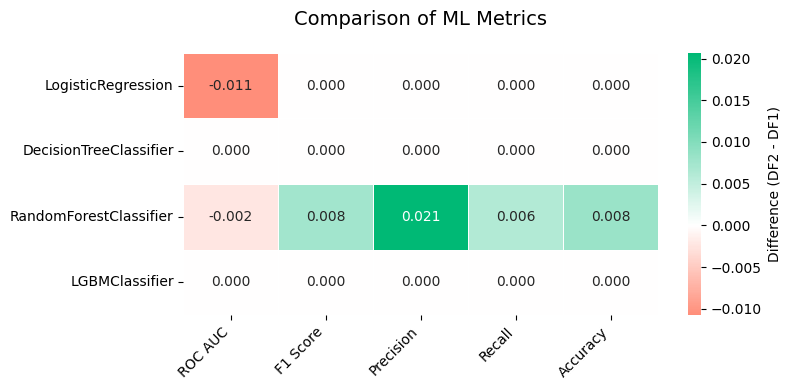

In [20]:
h.compare_metrics_heatmap(initial_metrics, log_delete_metrics)

C удалением столбцов преобразование уже работает не так хорошо, в некоторых случаях ухудшает модель

### 2.2 Создание нового признака "TotalIncome"
Возможно, сумма доходов будет лучше влиять на предсказание, чем доход каждого в отдельности

In [21]:
X_train_total_income = X_train_preprocessed.copy()
X_test_total_income = X_test_preprocessed.copy()

In [22]:
X_train_total_income['TotalIncome'] = X_train_total_income['ApplicantIncome'] + X_train_total_income['CoapplicantIncome']
X_train_total_income = X_train_total_income.drop(columns=['ApplicantIncome', 'CoapplicantIncome'])

X_test_total_income['TotalIncome'] = X_test_total_income['ApplicantIncome'] + X_test_total_income['CoapplicantIncome']
X_test_total_income = X_test_total_income.drop(columns=['ApplicantIncome', 'CoapplicantIncome'])

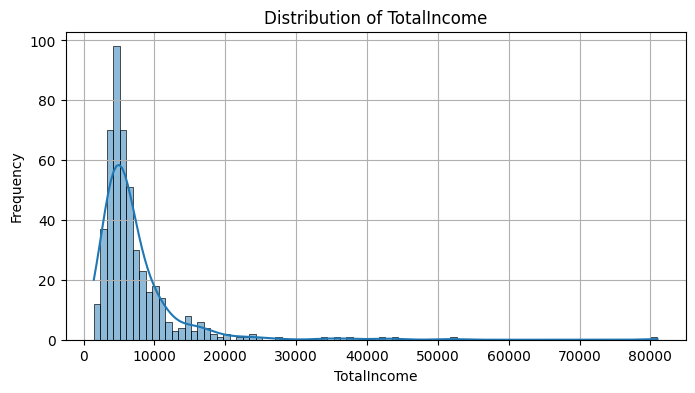

In [23]:
h.plot_hist_numeric(X_train_total_income, 'TotalIncome')

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

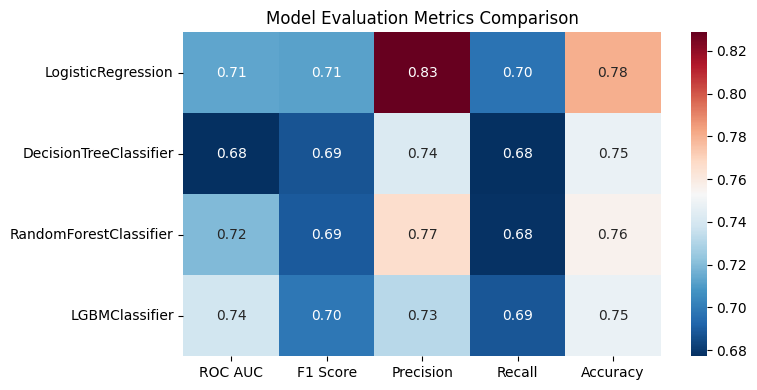

In [24]:
total_income_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_total_income,
    y_train=y_train,
    X_test=X_test_total_income,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.001163 -0.007727  -0.024851 -0.006250  -0.00813
 DecisionTreeClassifier -0.038517 -0.016535  -0.064349 -0.013372  -0.02439
 RandomForestClassifier -0.028343 -0.007419  -0.019024 -0.006250  -0.00813
 LGBMClassifier         -0.015407 -0.017390  -0.050933 -0.013372  -0.02439)

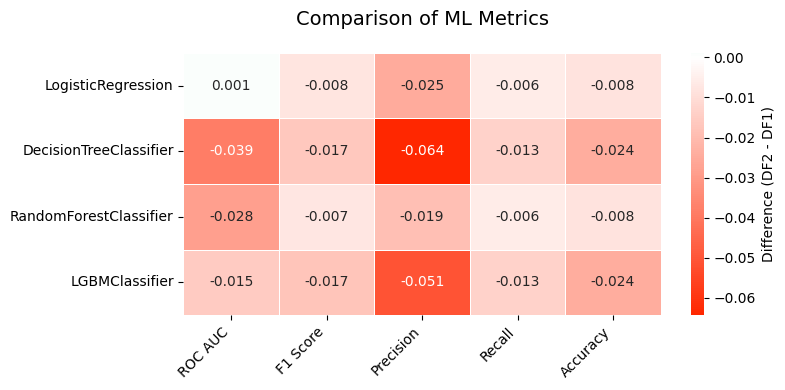

In [25]:
h.compare_metrics_heatmap(initial_metrics, total_income_metrics)

Такое преобразование только ухудшило модель и применять его мы точно не будем

### 2.3 Отношение кредита к доходу (Loan-to-Income Ratio, LIR)

In [26]:
X_train_lir = X_train_preprocessed.copy()
X_test_lir = X_test_preprocessed.copy()

In [27]:
X_train_lir['LIR'] = X_train_lir['LoanAmount'] / (X_train_lir['ApplicantIncome'] + X_train_lir['CoapplicantIncome'])
X_test_lir['LIR'] = X_test_lir['LoanAmount'] / (X_test_lir['ApplicantIncome'] + X_test_lir['CoapplicantIncome'])

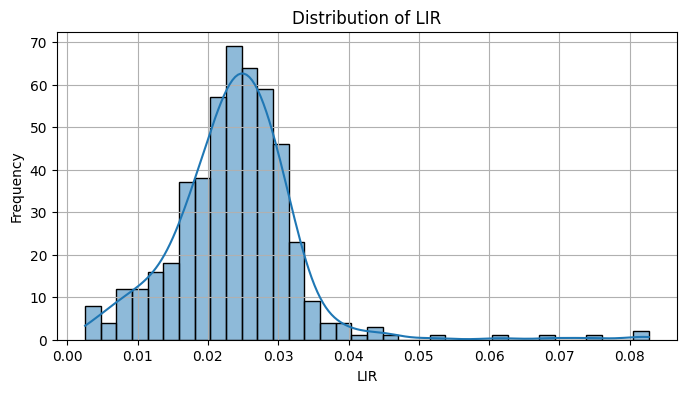

In [28]:
h.plot_hist_numeric(X_train_lir, 'LIR')

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

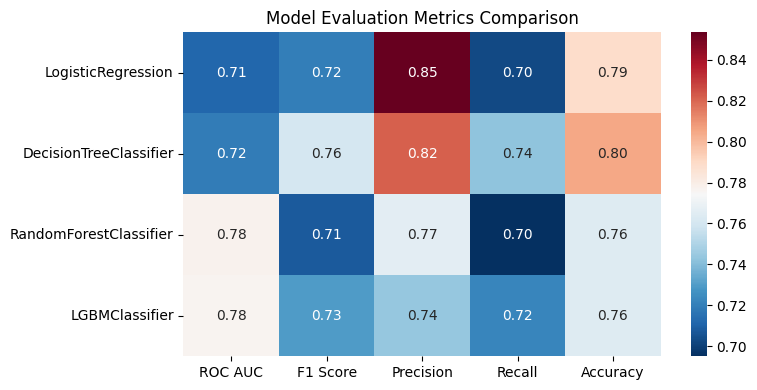

In [29]:
lir_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_lir,
    y_train=y_train,
    X_test=X_test_lir,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000000  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.002762  0.056063   0.015737  0.051890   0.03252
 RandomForestClassifier  0.030087  0.011122  -0.019270  0.010756   0.00000
 LGBMClassifier          0.022674  0.014163  -0.038879  0.020640  -0.00813)

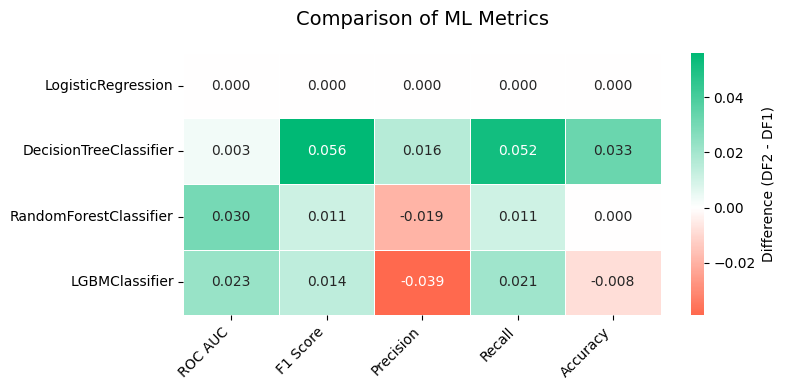

In [30]:
h.compare_metrics_heatmap(initial_metrics, lir_metrics)

Введение этой фичи положительно сказалось на метриках. Хоть в некоторых случаях значение precision стало меньше, это компенсировалось увеличением recall и итоговые метрики выросли

### 2.4 Биннинг для Loan_Amount_Term
Как мы убедились ранее, этот признак по сути категориальный, поэтому имеет смысл сделать биннинг и порядковое кодирование

#### 2.4.1 Без удаления

In [31]:
X_train_loan_amount_term_binning = X_train_preprocessed.copy()
X_test_loan_amount_term_binning = X_test_preprocessed.copy()

In [32]:
bins = [-np.inf, 180, 360, np.inf]
labels = [0, 1, 2]

X_train_loan_amount_term_binning['Loan_Amount_Term_bins'] = pd.cut(X_train_loan_amount_term_binning['Loan_Amount_Term'], bins=bins, labels=labels)
X_test_loan_amount_term_binning['Loan_Amount_Term_bins'] = pd.cut(X_test_loan_amount_term_binning['Loan_Amount_Term'], bins=bins, labels=labels)

c:\YandexDisk\IT\DS\loan-prediction\helper.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis", orient='h')


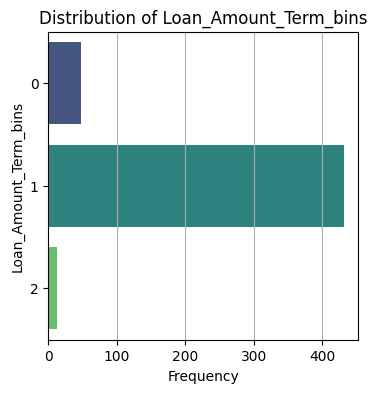

In [33]:
h.plot_hist_categorical(X_train_loan_amount_term_binning, 'Loan_Amount_Term_bins')

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

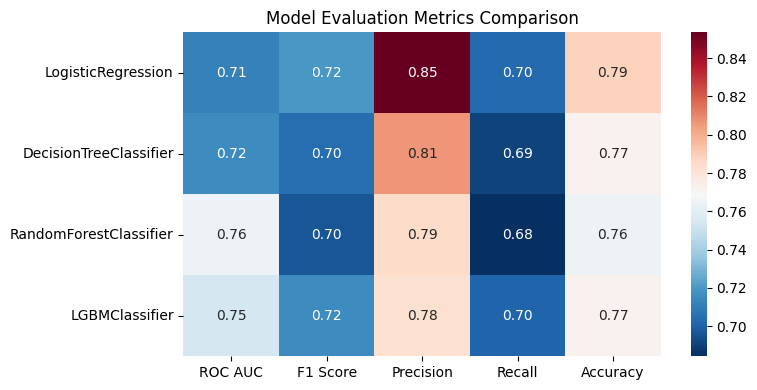

In [34]:
loan_amount_term_binning_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_loan_amount_term_binning,
    y_train=y_train,
    X_test=X_test_loan_amount_term_binning,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision  Recall  Accuracy
 LogisticRegression      0.000291       0.0        0.0     0.0       0.0
 DecisionTreeClassifier  0.000000       0.0        0.0     0.0       0.0
 RandomForestClassifier  0.015843       0.0        0.0     0.0       0.0
 LGBMClassifier          0.000000       0.0        0.0     0.0       0.0)

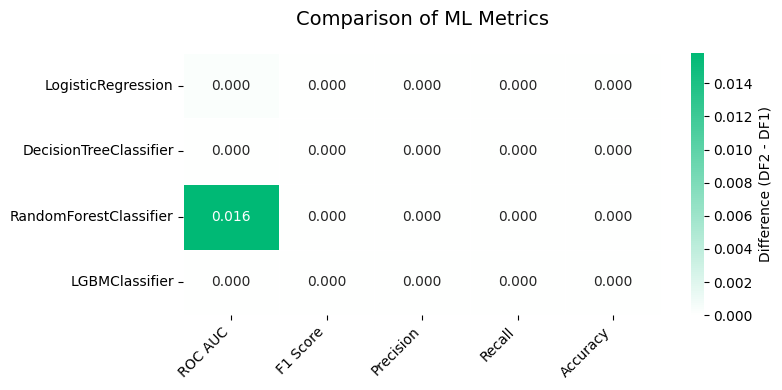

In [35]:
h.compare_metrics_heatmap(initial_metrics, loan_amount_term_binning_metrics)

Преобразование практически не дало результата

#### 2.4.2 С удалением

In [36]:
X_train_loan_amount_term_binning_del = X_train_preprocessed.copy()
X_test_loan_amount_term_binning_del = X_test_preprocessed.copy()

In [37]:
bins = [-np.inf, 180, 360, np.inf]
labels = [0, 1, 2]

X_train_loan_amount_term_binning_del['Loan_Amount_Term'] = pd.cut(X_train_loan_amount_term_binning_del['Loan_Amount_Term'], bins=bins, labels=labels)
X_test_loan_amount_term_binning_del['Loan_Amount_Term'] = pd.cut(X_test_loan_amount_term_binning_del['Loan_Amount_Term'], bins=bins, labels=labels)

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

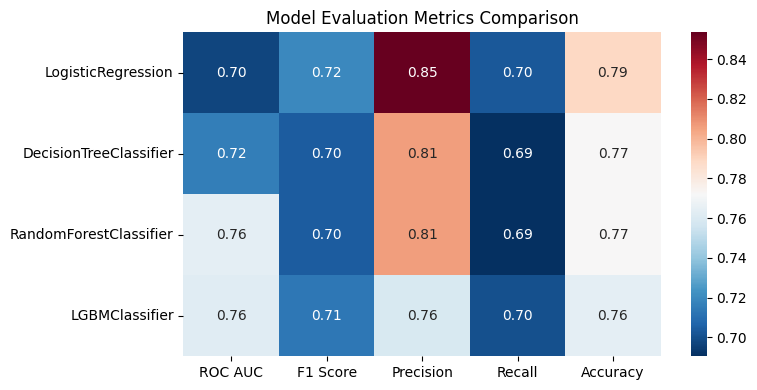

In [38]:
loan_amount_term_binning_metrics_del = h.train_evaluate_models(
    models=models,
    X_train=X_train_loan_amount_term_binning_del,
    y_train=y_train,
    X_test=X_test_loan_amount_term_binning_del,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.014244  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier  0.016134  0.007514   0.020694  0.006250   0.00813
 LGBMClassifier          0.008140 -0.002548  -0.023443 -0.000872  -0.00813)

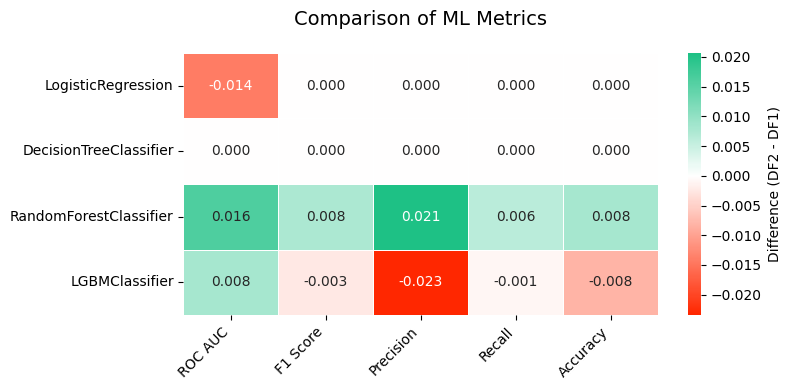

In [39]:
h.compare_metrics_heatmap(initial_metrics, loan_amount_term_binning_metrics_del)

Абсолютно нулевой эффект

### 2.5 Применение StandardScaler (стандартизация)

#### 2.5.1 Без удаления

In [40]:
X_train_standard_scaler = X_train_preprocessed.copy()
X_test_standard_scaler = X_test_preprocessed.copy()

In [41]:
scaler = StandardScaler()
scaler.fit(X_train_standard_scaler[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

X_train_standard_scaler[['ApplicantIncomeScaled', 'CoapplicantIncomeScaled', 'LoanAmountScaled']] = scaler.transform(X_train_standard_scaler[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
X_test_standard_scaler[['ApplicantIncomeScaled', 'CoapplicantIncomeScaled', 'LoanAmountScaled']] = scaler.transform(X_test_standard_scaler[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])


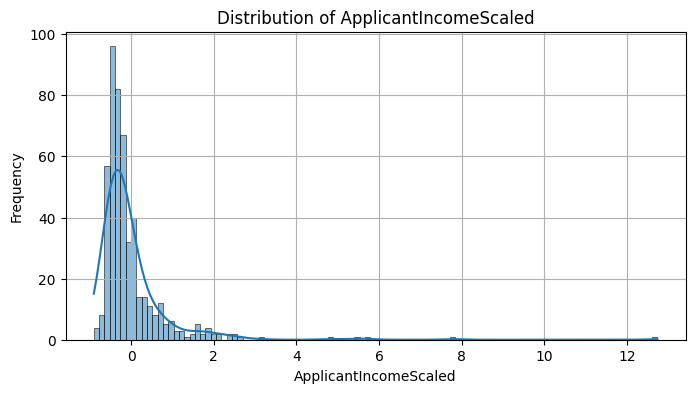

In [42]:
h.plot_hist_numeric(X_train_standard_scaler, 'ApplicantIncomeScaled')

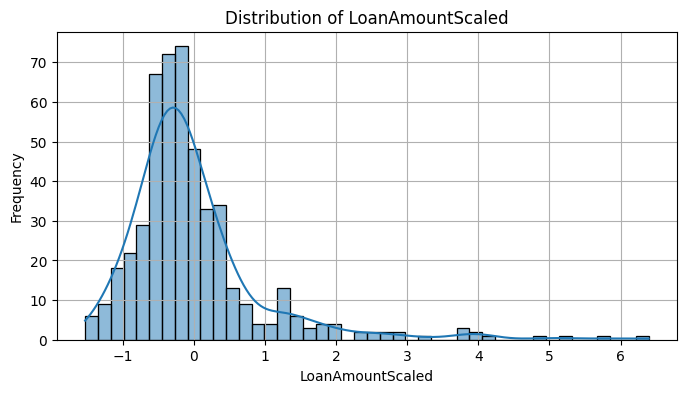

In [43]:
h.plot_hist_numeric(X_train_standard_scaler, 'LoanAmountScaled')

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

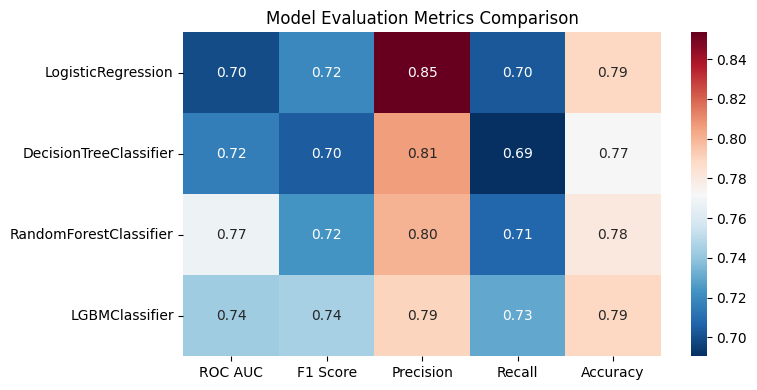

In [44]:
standard_scaler_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_standard_scaler,
    y_train=y_train,
    X_test=X_test_standard_scaler,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.012791  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier  0.020349  0.026276   0.015177  0.023256   0.01626
 LGBMClassifier         -0.010756  0.029266   0.007516  0.028634   0.01626)

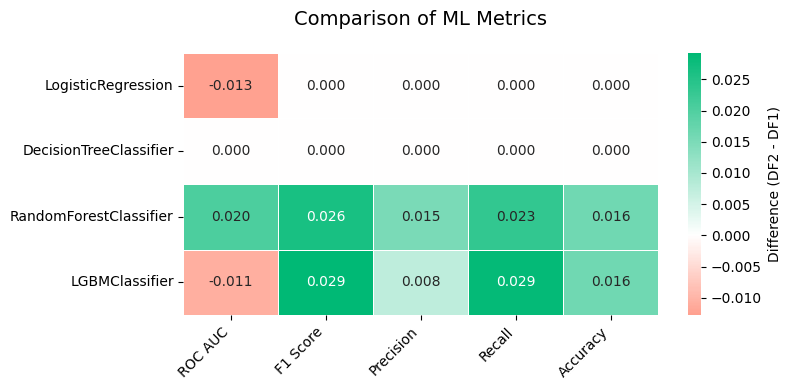

In [45]:
h.compare_metrics_heatmap(initial_metrics, standard_scaler_metrics)

(<Figure size 800x400 with 2 Axes>,
                              ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -1.250000e-02  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000e+00  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier  1.110223e-16  0.000000   0.000000  0.000000   0.00000
 LGBMClassifier         -1.075581e-02  0.029266   0.007516  0.028634   0.01626)

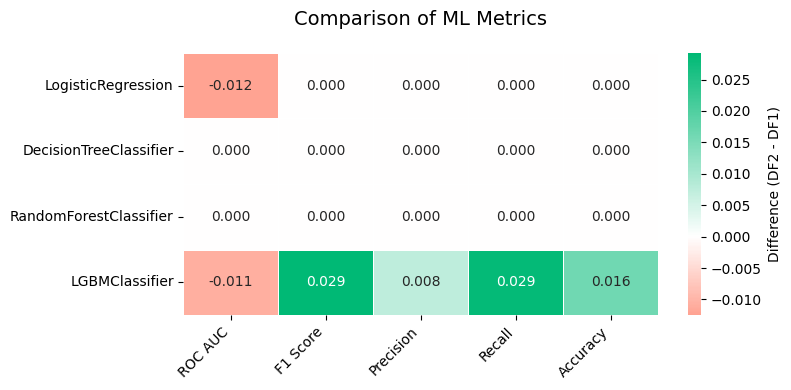

In [46]:
h.compare_metrics_heatmap(log_metrics, standard_scaler_metrics)

#### 2.5.2 С удалением

In [47]:
X_train_standard_scaler_del = X_train_preprocessed.copy()
X_test_standard_scaler_del = X_test_preprocessed.copy()

In [48]:
scaler = StandardScaler()
scaler.fit(X_train_standard_scaler_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

X_train_standard_scaler_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']] = scaler.transform(X_train_standard_scaler_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
X_test_standard_scaler_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']] = scaler.transform(X_test_standard_scaler_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

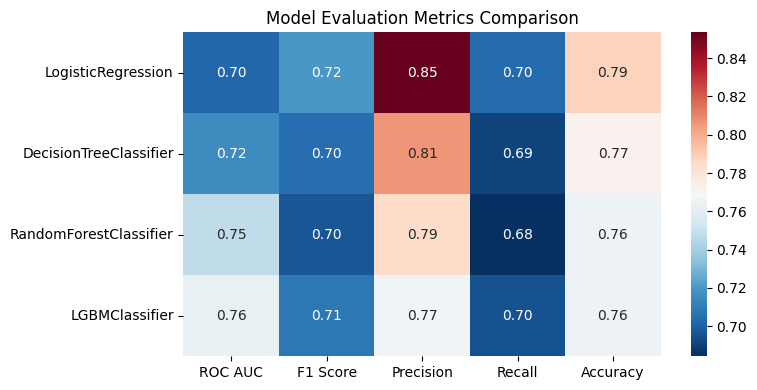

In [49]:
standard_scaler_metrics_del = h.train_evaluate_models(
    models=models,
    X_train=X_train_standard_scaler_del,
    y_train=y_train,
    X_test=X_test_standard_scaler_del,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision   Recall  Accuracy
 LogisticRegression     -0.009884  0.000000   0.000000  0.00000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.00000   0.00000
 RandomForestClassifier -0.000291  0.000000   0.000000  0.00000   0.00000
 LGBMClassifier          0.008430 -0.007532  -0.016594 -0.00625  -0.00813)

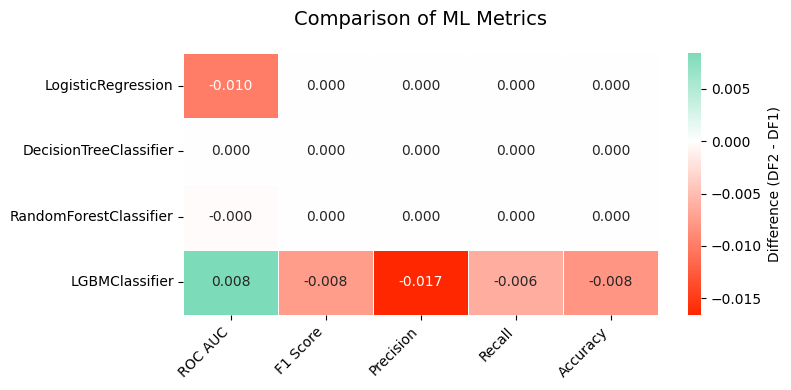

In [50]:
h.compare_metrics_heatmap(initial_metrics, standard_scaler_metrics_del)

Это только ухудшило модель, применять не будем

### 2.6 Нормализация

#### 2.6.1 Без удаления

In [51]:
X_train_normalised = X_train_preprocessed.copy()
X_test_normalised = X_test_preprocessed.copy()

In [52]:
scaler = MinMaxScaler()
scaler.fit(X_train_normalised[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

X_train_normalised[['ApplicantIncomeScaled', 'CoapplicantIncomeScaled', 'LoanAmountScaled']] = scaler.transform(X_train_normalised[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
X_test_normalised[['ApplicantIncomeScaled', 'CoapplicantIncomeScaled', 'LoanAmountScaled']] = scaler.transform(X_test_normalised[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

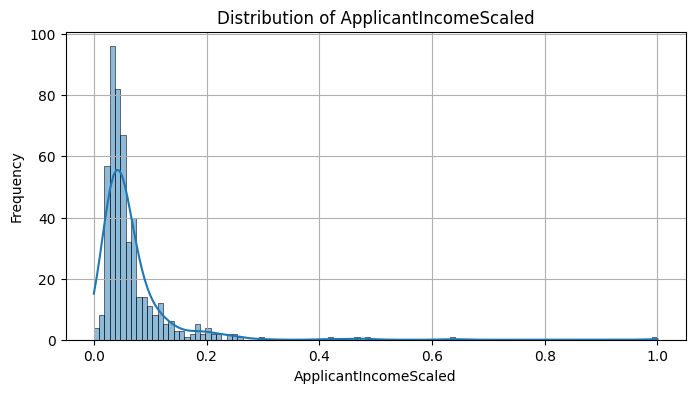

In [53]:
h.plot_hist_numeric(X_train_normalised, 'ApplicantIncomeScaled')

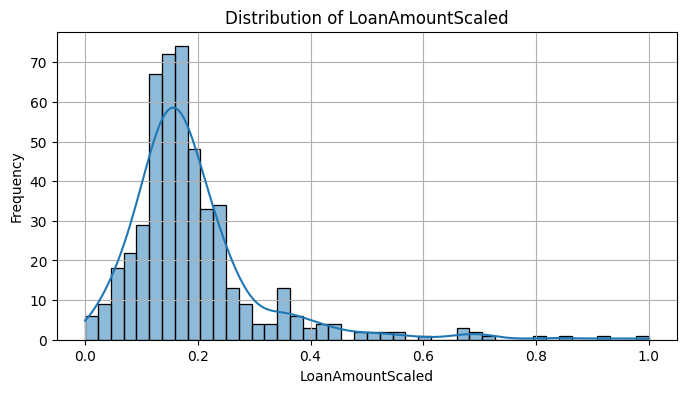

In [54]:
h.plot_hist_numeric(X_train_normalised, 'LoanAmountScaled')

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

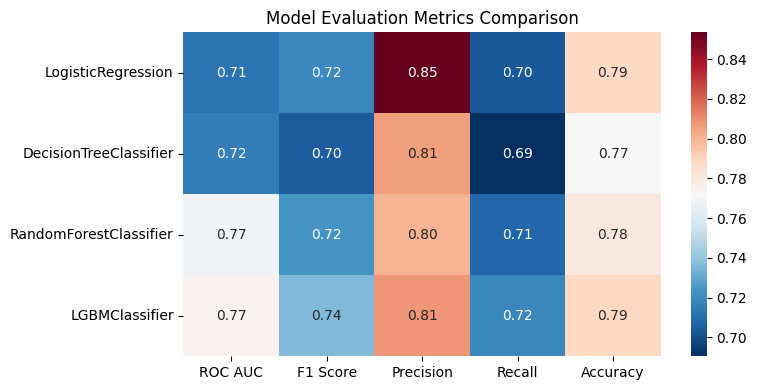

In [55]:
normalised_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_normalised,
    y_train=y_train,
    X_test=X_test_normalised,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.000000  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier  0.020785  0.026276   0.015177  0.023256   0.01626
 LGBMClassifier          0.020349  0.020324   0.025102  0.017878   0.01626)

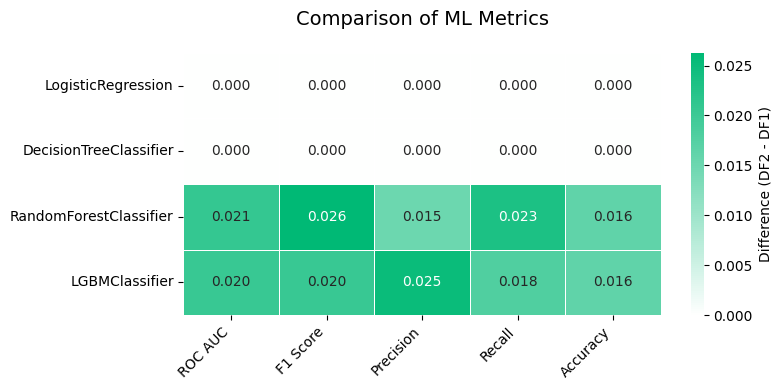

In [56]:
h.compare_metrics_heatmap(initial_metrics, normalised_metrics)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression      0.012791  0.000000   0.000000  0.000000       0.0
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000       0.0
 RandomForestClassifier  0.000436  0.000000   0.000000  0.000000       0.0
 LGBMClassifier          0.031105 -0.008942   0.017586 -0.010756       0.0)

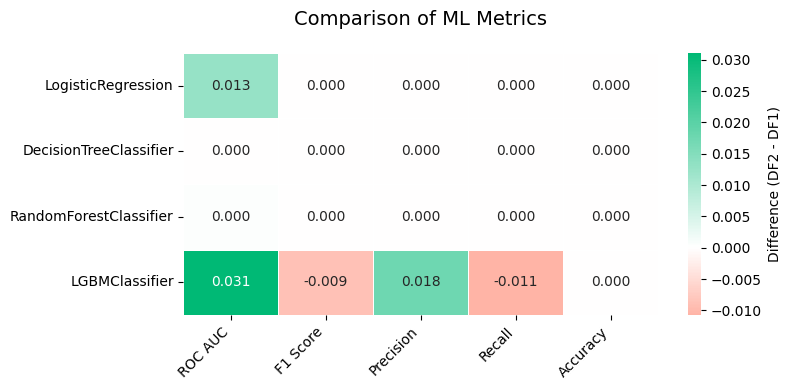

In [57]:
h.compare_metrics_heatmap(standard_scaler_metrics, normalised_metrics)

Неплохой результат для ансамблевых моделей, даже немного лучше чем стандартизация

#### 2.6.2 С удалением

In [58]:
X_train_normalised_del = X_train_preprocessed.copy()
X_test_normalised_del = X_test_preprocessed.copy()

In [59]:
scaler = MinMaxScaler()
scaler.fit(X_train_normalised[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

X_train_normalised_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']] = scaler.transform(X_train_normalised_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
X_test_normalised_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']] = scaler.transform(X_test_normalised_del[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

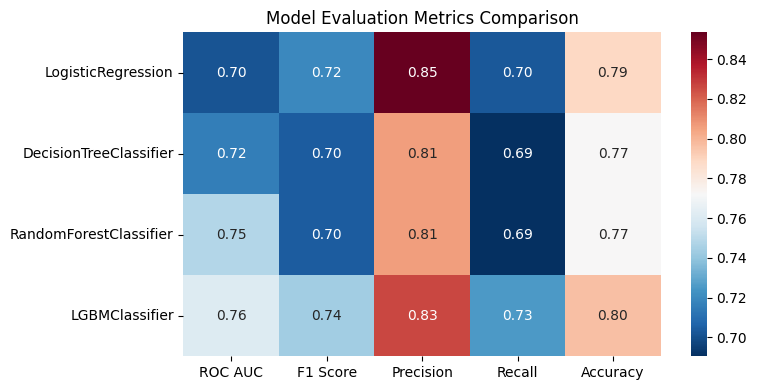

In [60]:
normalised_metrics_del = h.train_evaluate_models(
    models=models,
    X_train=X_train_normalised_del,
    y_train=y_train,
    X_test=X_test_normalised_del,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.010174  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier  0.000145  0.007514   0.020694  0.006250   0.00813
 LGBMClassifier          0.006977  0.028134   0.043736  0.024128   0.02439)

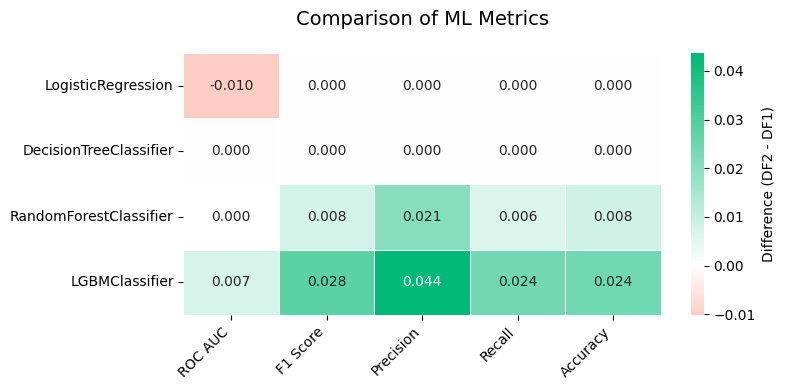

In [61]:
h.compare_metrics_heatmap(initial_metrics, normalised_metrics_del)

Эффект хуже чем без удаления

### 2.7 Обработка выбросов

In [62]:
X_train_no_outliers = X_train_preprocessed.copy()
X_test_no_outliers = X_test_preprocessed.copy()

In [63]:
X_train_no_outliers = h.winsorize_outliers(X_train_no_outliers, 'ApplicantIncome', upper_bound=25000)
X_train_no_outliers = h.winsorize_outliers(X_train_no_outliers, 'CoapplicantIncome', upper_bound=10000)
X_train_no_outliers = h.winsorize_outliers(X_train_no_outliers, 'LoanAmount', upper_bound=500)

X_test_no_outliers = h.winsorize_outliers(X_test_no_outliers, 'ApplicantIncome', upper_bound=25000)
X_test_no_outliers = h.winsorize_outliers(X_test_no_outliers, 'CoapplicantIncome', upper_bound=10000)
X_test_no_outliers = h.winsorize_outliers(X_test_no_outliers, 'LoanAmount', upper_bound=500)

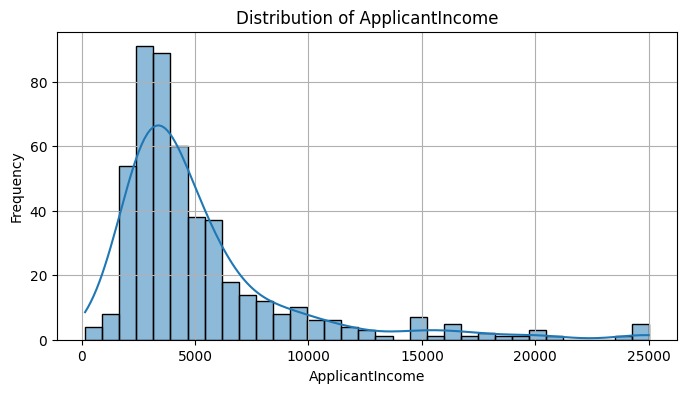

In [64]:
h.plot_hist_numeric(X_train_no_outliers, 'ApplicantIncome')

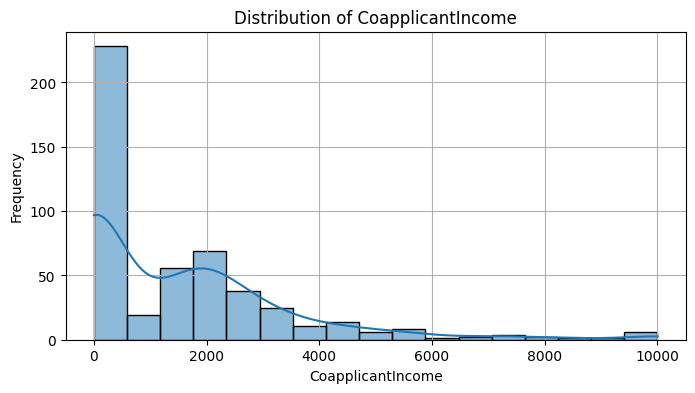

In [65]:
h.plot_hist_numeric(X_train_no_outliers, 'CoapplicantIncome')

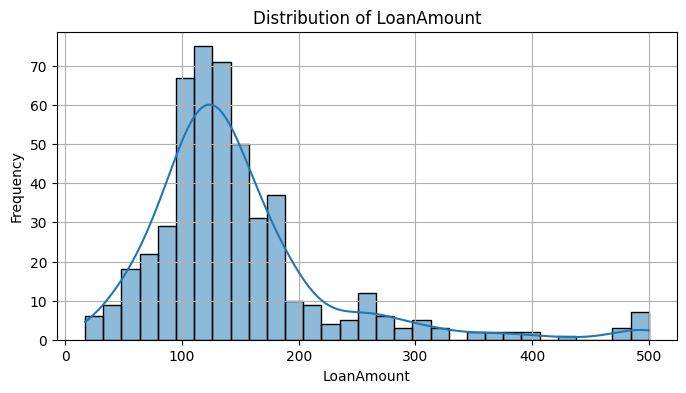

In [66]:
h.plot_hist_numeric(X_train_no_outliers, 'LoanAmount')

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

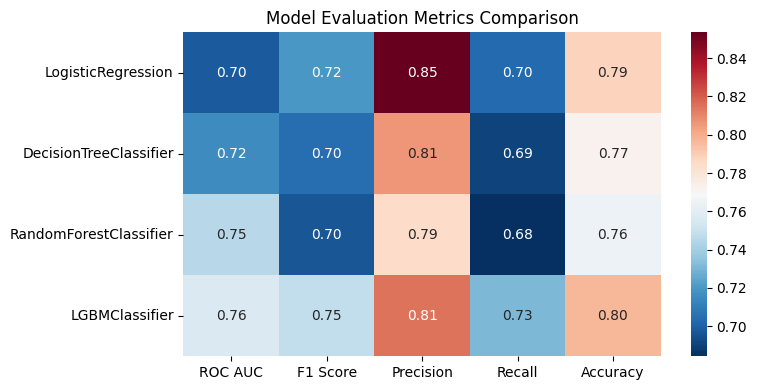

In [67]:
no_outliers_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_no_outliers,
    y_train=y_train,
    X_test=X_test_no_outliers,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.013953  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier -0.002180  0.000000   0.000000  0.000000   0.00000
 LGBMClassifier          0.002326  0.032753   0.032176  0.029506   0.02439)

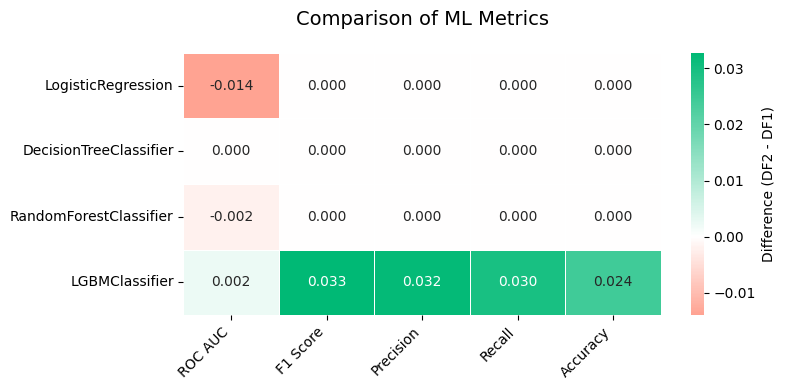

In [68]:
h.compare_metrics_heatmap(initial_metrics, no_outliers_metrics)

Наблюдаем улучшение для градиентного бустинга

### 2.8 Комбинируем работу с выбросами, логарифмирование и нормализацию

In [69]:
X_train_combination = X_train_preprocessed.copy()
X_test_combination = X_test_preprocessed.copy()

In [70]:
X_train_combination = h.winsorize_outliers(X_train_combination, 'ApplicantIncome', upper_bound=25000)
X_train_combination = h.winsorize_outliers(X_train_combination, 'CoapplicantIncome', upper_bound=10000)
X_train_combination = h.winsorize_outliers(X_train_combination, 'LoanAmount', upper_bound=500)

X_train_combination['ApplicantIncomeNew'] = np.log1p(X_train_combination['ApplicantIncome'])
X_train_combination['CoapplicantIncomeNew'] = np.log1p(X_train_combination['CoapplicantIncome'])
X_train_combination['LoanAmountNew'] = np.log1p(X_train_combination['LoanAmount'])

scaler = MinMaxScaler()
scaler.fit(X_train_combination[['ApplicantIncomeNew', 'CoapplicantIncomeNew', 'LoanAmountNew']])

X_train_combination[['ApplicantIncomeNew', 'CoapplicantIncomeNew', 'LoanAmountNew']] = scaler.transform(X_train_combination[['ApplicantIncomeNew', 'CoapplicantIncomeNew', 'LoanAmountNew']])


X_test_combination = h.winsorize_outliers(X_test_combination, 'ApplicantIncome', upper_bound=25000)
X_test_combination = h.winsorize_outliers(X_test_combination, 'CoapplicantIncome', upper_bound=10000)
X_test_combination = h.winsorize_outliers(X_test_combination, 'LoanAmount', upper_bound=500)

X_test_combination['ApplicantIncomeNew'] = np.log1p(X_test_combination['ApplicantIncome'])
X_test_combination['CoapplicantIncomeNew'] = np.log1p(X_test_combination['CoapplicantIncome'])
X_test_combination['LoanAmountNew'] = np.log1p(X_test_combination['LoanAmount'])

X_test_combination[['ApplicantIncomeNew', 'CoapplicantIncomeNew', 'LoanAmountNew']] = scaler.transform(X_test_combination[['ApplicantIncomeNew', 'CoapplicantIncomeNew', 'LoanAmountNew']])

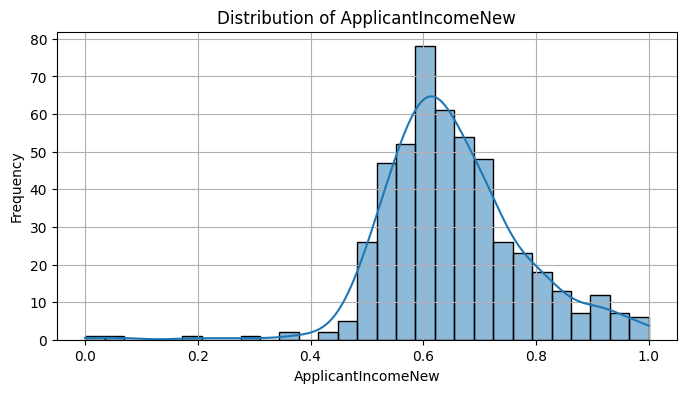

In [71]:
h.plot_hist_numeric(X_train_combination, 'ApplicantIncomeNew')

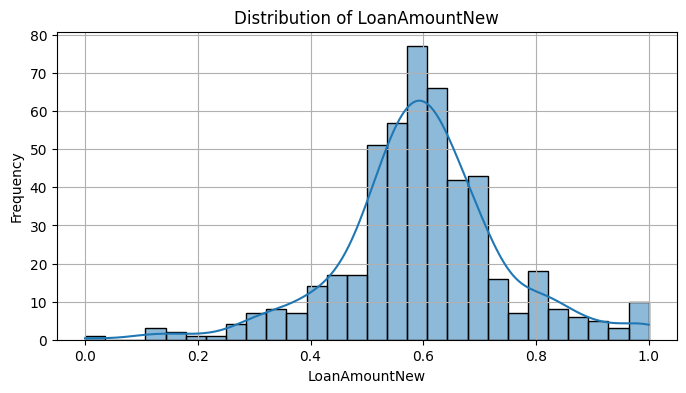

In [72]:
h.plot_hist_numeric(X_train_combination, 'LoanAmountNew')

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

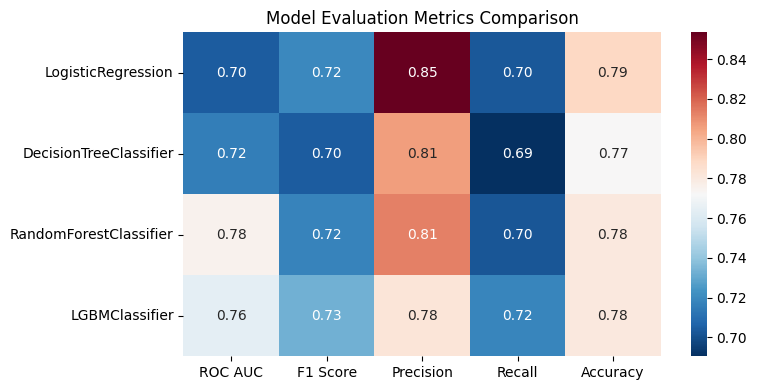

In [73]:
combination_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_combination,
    y_train=y_train,
    X_test=X_test_combination,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.007267  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier  0.027471  0.020909   0.027678  0.017878   0.01626
 LGBMClassifier          0.010174  0.017250  -0.000322  0.017006   0.00813)

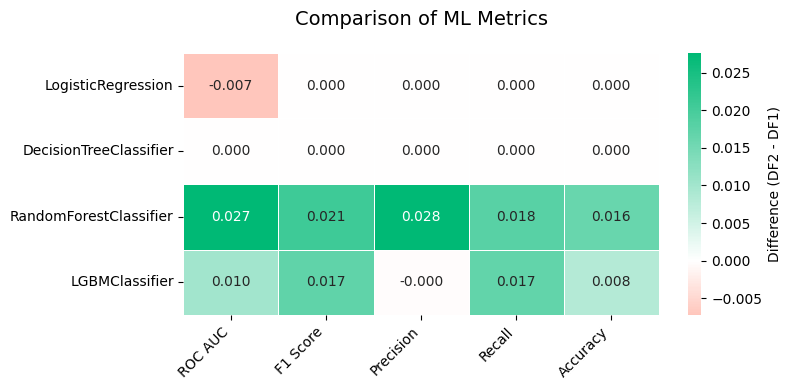

In [74]:
h.compare_metrics_heatmap(initial_metrics, combination_metrics)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.007267  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.000000  0.000000   0.000000  0.000000   0.00000
 RandomForestClassifier  0.006686 -0.005366   0.012501 -0.005378   0.00000
 LGBMClassifier         -0.010174 -0.003074  -0.025424 -0.000872  -0.00813)

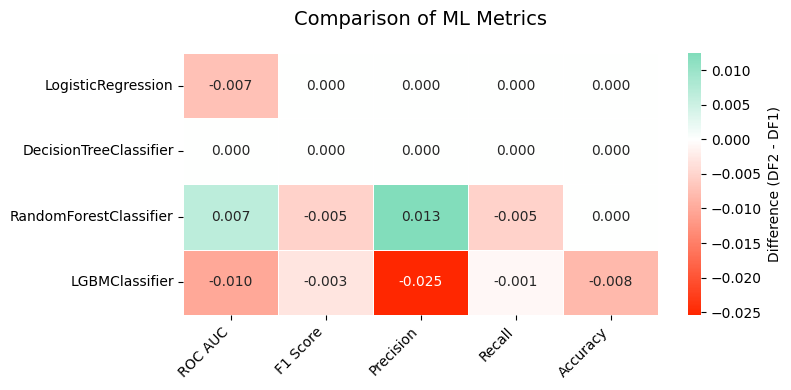

In [75]:
h.compare_metrics_heatmap(normalised_metrics, combination_metrics)

Комбинированный подход дал результат хуже, чем простая нормализация. Ее и будем использовать

### 2.9 Таргетное кодирование

In [76]:
# немного изменим наш пайплайн
preprocessor_target_encoding = Pipeline([
    ('most_frequent_impute', ColumnTransformer(
        [
            ('most_frequent_numeric', SimpleImputer(strategy='most_frequent'), most_frequent_numeric_cols),
            ('most_frequent_cat', SimpleImputer(strategy='most_frequent'), most_frequent_cat_cols)
        ],
        remainder='passthrough', 
        verbose_feature_names_out=False
    )),

    ('mean_impute', ColumnTransformer(
        [('mean', SimpleImputer(strategy='mean'), mean_imputer_cols)],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    
    ('encode', ColumnTransformer(
        [('encoder', TargetEncoder(categories=category_orders), categorical_cols)],
        remainder='passthrough',
        verbose_feature_names_out=False
    ))
])
preprocessor_target_encoding.set_output(transform="pandas")

Pipeline(steps=[('most_frequent_impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('most_frequent_numeric',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Dependents',
                                                   'Loan_Amount_Term']),
                                                 ('most_frequent_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Gender', 'Married',
                                                   'Self_Employed'])],
                                   verbose_feature_names_out=False)),
                ('mean_impute',
                 Colum...
                                                  ['LoanAmount'])],
                                   verbose_feature_names_out=False)),
                ('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(categories=[['Male',
                                                                             'Female'],
                                                                            ['No',
                                                                             'Yes'],
                                                                            ['Not '
                                                                             'Graduate',
                                                                             'Graduate'],
                                                                            ['No',
                                                                             'Yes'],
                                                                            ['Rural',
                                                                             'Semiurban',
                                                                             'Urban']]),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])],
                                   verbose_feature_names_out=False))])

In [77]:
X_train_preprocessed_target_encoding = preprocessor_target_encoding.fit_transform(X_train, y_train)
X_test_preprocessed_target_encoding = preprocessor_target_encoding.transform(X_test)

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

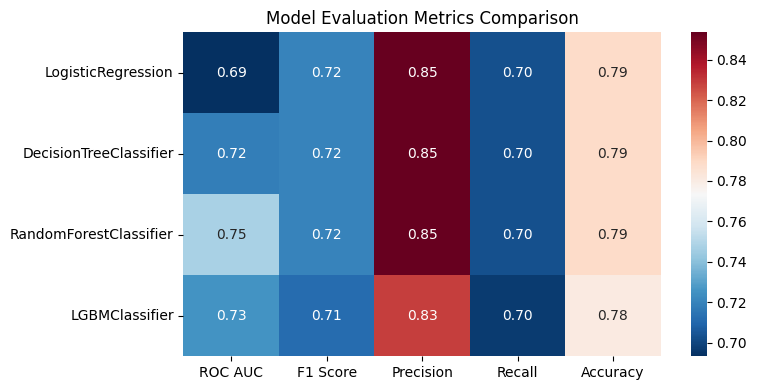

In [78]:
target_encoder_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_preprocessed_target_encoding,
    y_train=y_train,
    X_test=X_test_preprocessed_target_encoding,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.018314  0.000000   0.000000  0.000000   0.00000
 DecisionTreeClassifier  0.002180  0.015343   0.047469  0.012500   0.01626
 RandomForestClassifier -0.000145  0.022858   0.068163  0.018750   0.02439
 LGBMClassifier         -0.028488 -0.003522   0.045988 -0.004506   0.00813)

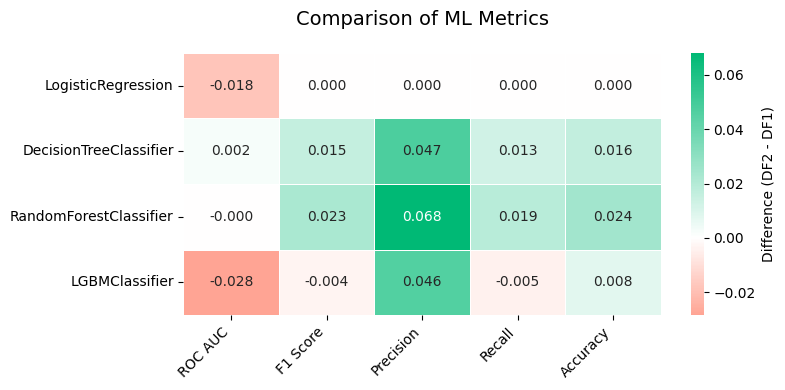

In [79]:
h.compare_metrics_heatmap(initial_metrics, target_encoder_metrics)

По некоторым метрикам наблюдается прирост, но не для ROC AUC

### 2.10 Работа с дисбалансом классов

#### 2.10.1 На уровне моделей

In [80]:
models_balanced = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear', class_weight='balanced')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4, class_weight='balanced')),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED, class_weight='balanced'))
]

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

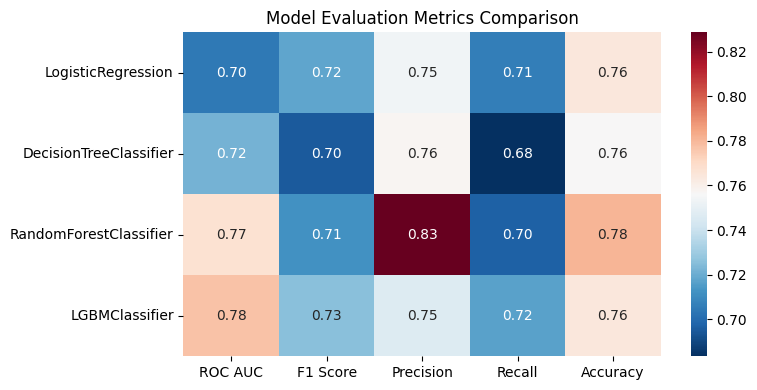

In [81]:
balanced_metrics = h.train_evaluate_models(
    models=models_balanced,
    X_train=X_train_preprocessed,
    y_train=y_train,
    X_test=X_test_preprocessed,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.007267 -0.002116  -0.099728  0.002762  -0.02439
 DecisionTreeClassifier  0.005959 -0.009185  -0.048471 -0.007122  -0.01626
 RandomForestClassifier  0.019331  0.015131   0.043312  0.012500   0.01626
 LGBMClassifier          0.023256  0.010424  -0.036453  0.015262  -0.00813)

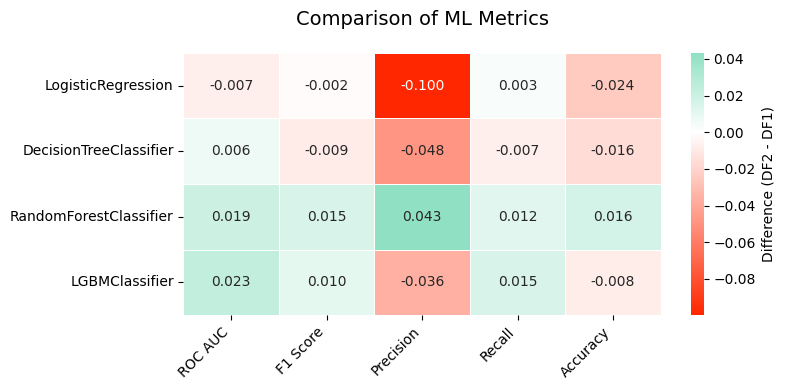

In [82]:
h.compare_metrics_heatmap(initial_metrics, balanced_metrics)

#### 2.10.2 Используя SMOTE

In [83]:
smote = SMOTE(random_state=SEED)
X_train_preprocessed_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

In [84]:
# убедимся, что классы теперь сбалансированны
y_train_smote.value_counts()

Loan_Status
0    342
1    342
Name: count, dtype: int64

[LightGBM] [Info] Number of positive: 342, number of negative: 342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 684, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

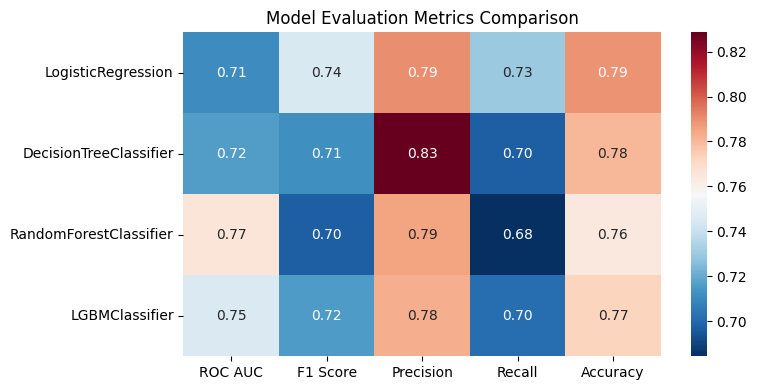

In [85]:
smote_metrics = h.train_evaluate_models(
    models=models,
    X_train=X_train_preprocessed_smote,
    y_train=y_train_smote,
    X_test=X_test_preprocessed,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision   Recall  Accuracy
 LogisticRegression     -0.000581  0.025061  -0.063323  0.02689   0.00000
 DecisionTreeClassifier  0.000436  0.007617   0.022618  0.00625   0.00813
 RandomForestClassifier  0.017733  0.000000   0.000000  0.00000   0.00000
 LGBMClassifier         -0.008721  0.000000   0.000000  0.00000   0.00000)

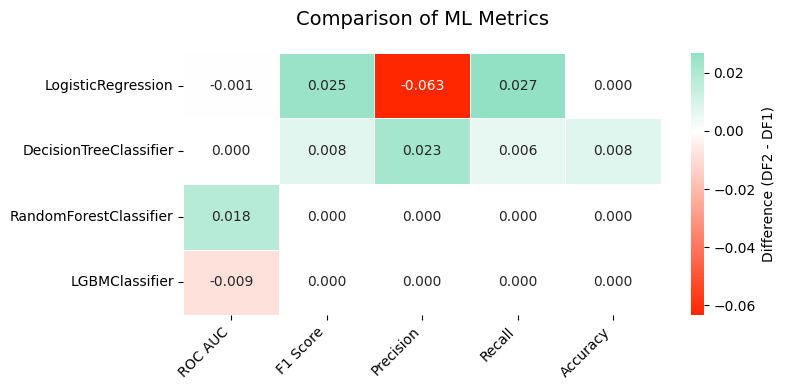

In [86]:
h.compare_metrics_heatmap(initial_metrics, smote_metrics)

### 2.11 Итоговый результат

In [87]:
X_train_preprocessed_final = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed_final = preprocessor.transform(X_test)

In [88]:
# Комбинируем все лучшие преобразования

X_train_preprocessed_final['LIR'] = X_train_preprocessed_final['LoanAmount'] / (X_train_preprocessed_final['ApplicantIncome'] + X_train_preprocessed_final['CoapplicantIncome'])
X_test_preprocessed_final['LIR'] = X_test_preprocessed_final['LoanAmount'] / (X_test_preprocessed_final['ApplicantIncome'] + X_test_preprocessed_final['CoapplicantIncome'])

scaler = MinMaxScaler()
scaler.fit(X_train_preprocessed_final[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

X_train_preprocessed_final[['ApplicantIncomeScaled', 'CoapplicantIncomeScaled', 'LoanAmountScaled']] = scaler.transform(X_train_preprocessed_final[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
X_test_preprocessed_final[['ApplicantIncomeScaled', 'CoapplicantIncomeScaled', 'LoanAmountScaled']] = scaler.transform(X_test_preprocessed_final[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])


[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

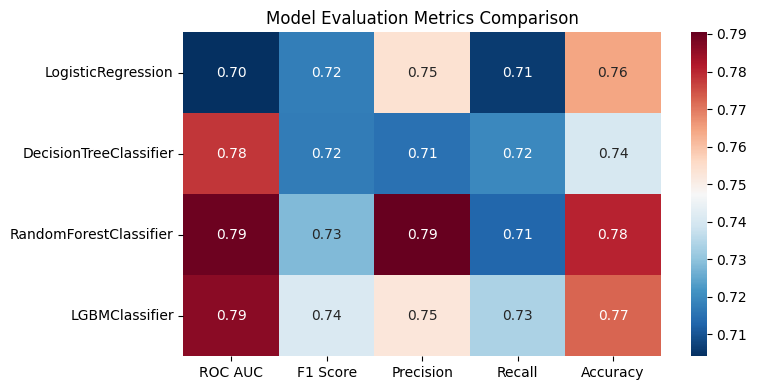

In [89]:
final_metrics = h.train_evaluate_models(
    models=models_balanced,
    X_train=X_train_preprocessed_final,
    y_train=y_train,
    X_test=X_test_preprocessed_final,
    y_test=y_test
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 LogisticRegression     -0.007558 -0.002116  -0.099728  0.002762  -0.02439
 DecisionTreeClassifier  0.062209  0.012589  -0.091065  0.028779  -0.03252
 RandomForestClassifier  0.041715  0.031264   0.005116  0.028634   0.01626
 LGBMClassifier          0.032267  0.025197  -0.030139  0.032267   0.00000)

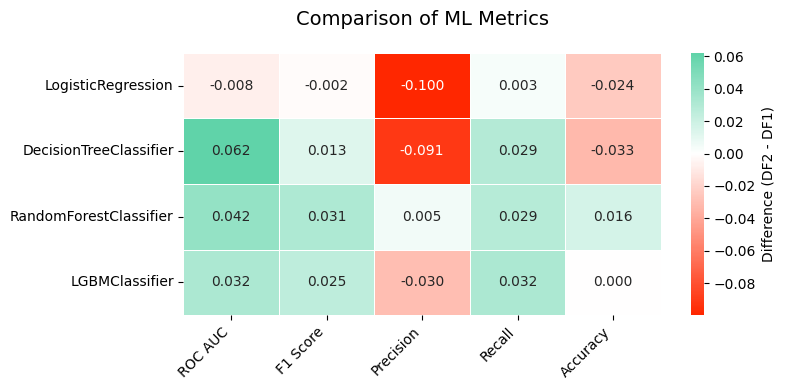

In [90]:
h.compare_metrics_heatmap(initial_metrics, final_metrics)